<table style='border: none' align='left'>
   <tr style='border: none'>
      <th style='border: none'><font size='5' face='verdana' color='black'><b>Use statsmodels to forecast time series data</b></th>
      <th style='border: none'><img src='https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true' alt='Watson Machine Learning icon' height='40' width='40'></th>
   </tr>
</table>

This notebook takes you through the steps of building a time series model. You will set up your environment and you require the following data for this notebook: <a href="https://datamarket.com/data/set/22t8/monthly-number-of-employed-persons-in-australia-thousands-feb-1978-apr-1991" target="_blank" rel="noopener noreferrer">Monthly number of employed persons in Australia</a>. Next, you will learn how to visualize and modify the time series data with the necessary packages. The notebook will teach you how to analyze the time series data and come to conclusions about the stationarity and optimal parameters of the time series data and its model. After you've selected the model with tuned parameters, you will be able to efficiently forecasts the time series data.

This notebook uses Python 3.5 and the statsmodels package.

## Learning goals
- Load data saved as a project asset as a dataframe
    - Create a time series object
- Explore data
    - Check the stationarity of the time series
        - Seasonal decomposition
        - Dicky-Fuller test
- Prepare data - stationarizing the series
- Optimize the ARIMA parameters and create the model
    - ACF and PACF plots to identify parameters
    - Use grid search for ARIMA
- Train the model
- Test the model using forecasting

## Contents

1. [Load data](#loaddata)
2. [Explore data](#explore)
3. [Prepare data](#prepare)
4. [Model selection](#modelselection)
5. [Summary and next steps](#summary)

<a id='loaddata'></a>
## 1. Load data

In this section, you will load the time series data as a dataframe and modify it so that the index is a datetime variable.

This dataset contains records of the number of employed persons in Australia per month. You'll use the data set starting from February 1985 and onwards.

To download the "Monthly number of employed persons in Australia" dataset:

1. Go to <a href="https://datamarket.com/data/set/22t8/monthly-number-of-employed-persons-in-australia-thousands-feb-1978-apr-1991" target="_blank" rel="noopener noreferrer">https://datamarket.com/data/set/22t8/monthly-number-of-employed-persons-in-australia-thousands-feb-1978-apr-1991</a> and select Export to download the file in CSV format. Open the file to **remove the last line of the first column** that says `Monthly number of employed persons in Australia: thousands. Feb 1978 ? Apr 1991`.
2. To load the `monthly-number-of-employed-perso.csv` file into your notebook, click the **Find and add data** icon on the notebook action bar. Drop the file into the box or browse to select the file. The file is loaded to your object storage and appears in the Data Assets section of the project. 
3. To load the data from the `monthly-number-of-employed-perso.csv` file into a dataframe, click in `Load data as a dataframe` code cell and then the data icon  at the top right of the toolbar. Select **Insert to code > Insert Pandas DataFrame** under the file name.
4. Remove the following 2 lines: `df_data_1 = pd.read_csv(body)` and `df_data_1.head()` that are included at the end of the inserted code.
5. Run the cell.


In [1]:
# First Upgrade the numpy package.
!pip install --user numpy --upgrade

Requirement already up-to-date: numpy in /home/dsxuser/.local/lib/python3.5/site-packages


In [2]:
# Load data as a dataframe.

import sys
import datetime

# To load the data, select Insert to code > Insert Pandas DataFrame under the monthly-number-of-employed-perso.csv filename in the data panel
# Your credentials will be added here.



# After running Insert to code, remove the two lines (above) with df_data_1
# Convert month column to datetime index in pandas dataframe.
import datetime
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m')
employed_data = pd.read_csv(body, parse_dates=['Month'], index_col = 'Month', date_parser=dateparse)
employed_data = (employed_data['1985':'1989']).rename(columns={"Monthly number of employed persons in Australia: thousands. Feb 1978 ? Apr 1991": "Employed"})

employed_data.head()

Employed
Month               
1985-01-01    6452.4
1985-02-01    6595.7
1985-03-01    6657.4
1985-04-01    6588.8
1985-05-01    6658.0

Before the data set is loaded as a dataframe, the *Month* column is converted into a datetime type variable. Each date is unique, which allows the *Month* column to be made the index of the data set so that the dataframe can be used as a time series object.

Now, when you list the dataframe information, you can see the `DatatimeIndex` and the single column representing the number of employed persons in Australia (in thousands).

In [3]:
# Display the columns of the dataframe.
employed_data.rename(columns = {'Monthly number of employed persons in Australia (thousands)': 'Employed'}, inplace = True)
employed_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 1985-01-01 to 1989-12-01
Data columns (total 1 columns):
Employed    60 non-null float64
dtypes: float64(1)
memory usage: 960.0 bytes


Import the necessary data visualization packages and plot the time series object to observe the pattern of the number of employed persons in Australia (in thousands) changing with time.

In [4]:
# Import the following package for visualizations.
import matplotlib.pyplot as plt

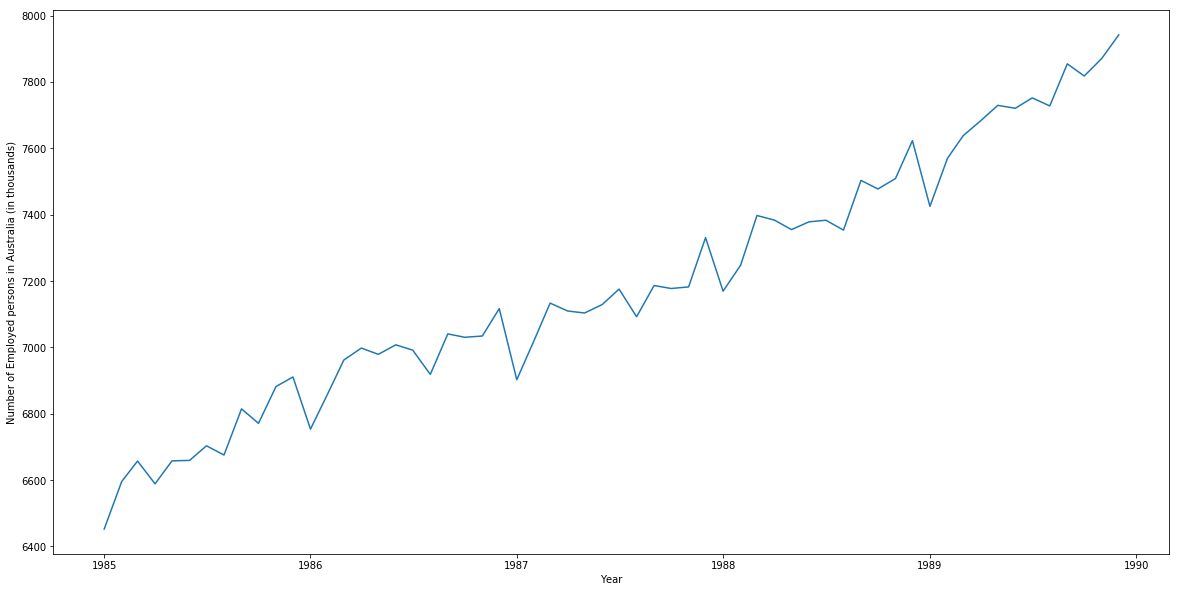

In [5]:
# Plot time series data.
import matplotlib.dates as mdates
plt.figure(figsize=(20, 10))
plt.xlabel('Year')
plt.ylabel('Number of Employed persons in Australia (in thousands)')
plt.plot(employed_data.index.to_pydatetime(), employed_data['Employed'])

<a id='explore'></a>
## 2. Explore data

In this section, you will explore the data to learn more about the stationarity of the series and determine the steps to take for data preparation.

### Check stationarity of time series<a id='station'></a>

You need to check the stationarity of the time series, since many models assume that the series is stationary. A time series is stationary when the mean, variance, and covariance of the data are constant and not dependent on time.

**Seasonal Decomposition**

Decompose the time series to observe the trend and seasonality in the data.

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


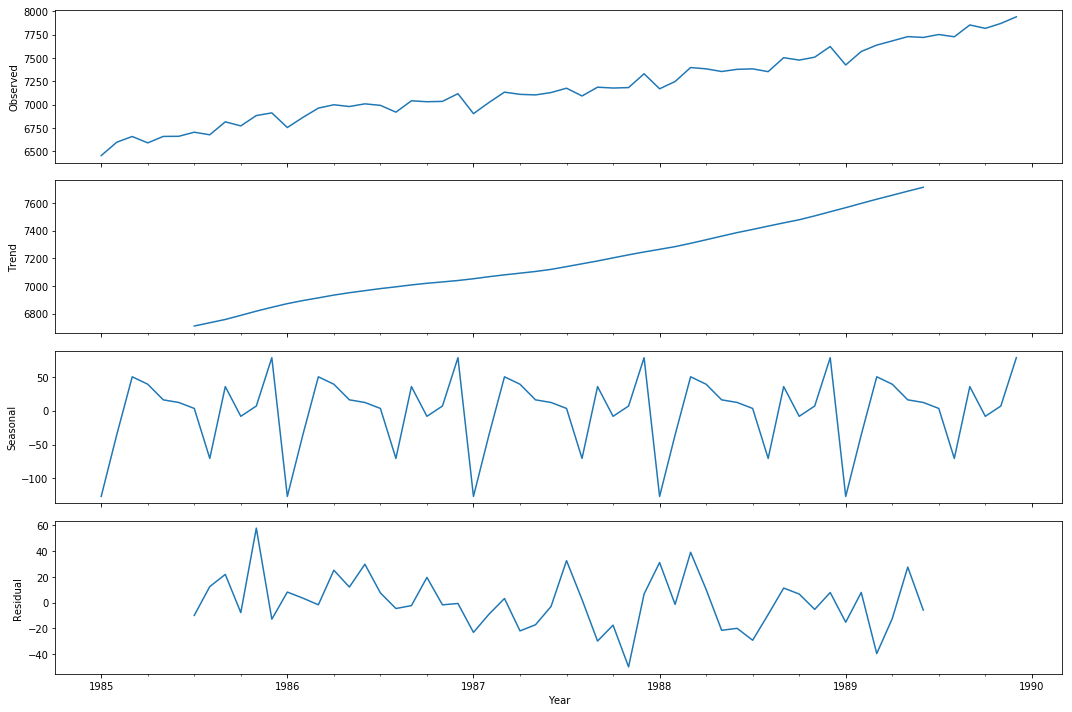

In [6]:
# Decomposition of the time series data.
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] =15, 10
decomposition = sm.tsa.seasonal_decompose(employed_data['Employed'], model = 'additive')
fig = decomposition.plot()
plt.xlabel('Year')
plt.show()

As you can see, the trend changes over time, so you can infer that the series is not stationary. You can also use another method, called the Dicky-Fuller test, to confirm this observation.

**Dicky-Fuller Test** <br>

Use the Dicky-Fuller test to check the stationarity of the time series data.


In [7]:
# Augmented Dicky-Fuller test.
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(employed_data['Employed'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  1.521774
p-value                         0.997603
Number of Lags Used            11.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


The null hypothesis  $H_{o}$  assumes that the time series is dependent on time (that it is non-stationary). Since the `Test Statistic` is larger than the `Critical Values`, we cannot reject the null hypothesis and understand that the series is **non-stationary**.

<a id='prepare'></a>
## 3. Prepare data

3.1 [ACF & PACF plots](#acf)
<br>
3.2 [Stationarize the time series data](#station)

### 3.1 ACF & PACF plots<a id='acf'></a>

A common tool used to forecast time series data is the `ARIMA` (**A**uto **R**egressive **I**ntegrated **M**oving **A**verage) model. The model has 3 parameters 
- `p` - the parameter associated with the Auto-Regressive part of the ARIMA model. You can use the **PACF (partial autocorrelation function)** plot to find the optimal value.
- `d` - the parameter associated with the Integration part of the ARIMA model. This is the **order of difference**, or the number of times the time series is differenced in order to stationarize the series.
- `q` - the parameter associated with the Moving Average part of the ARIMA model. You can use the **ACF (autocorrelation function)** plot to find the optimal value.

Here are the ACF and PACF plots of the original time series data.

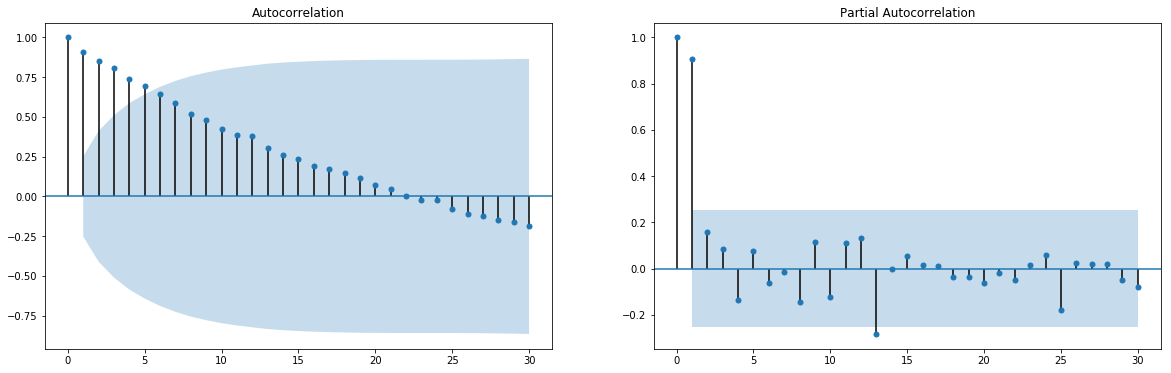

In [8]:
# Visualize the ACF and PACF plots.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plot_acf(employed_data['Employed'], ax = ax1, lags = 30)
plot_pacf(employed_data['Employed'], ax = ax2, lags = 30)
plt.show()

But since the series is not stationary, you will first use differencing before finding the parameters for the model.

### 3.2 Stationarize the time series data<a id='station'></a>

**Differencing** is used to remove the non-stationarity caused by the trend. The number of differences needed to remove stationarity determines the parameter `d`, for the Integration component of the ARIMA model. Run the following code to difference the data twice and plot the resulting values.

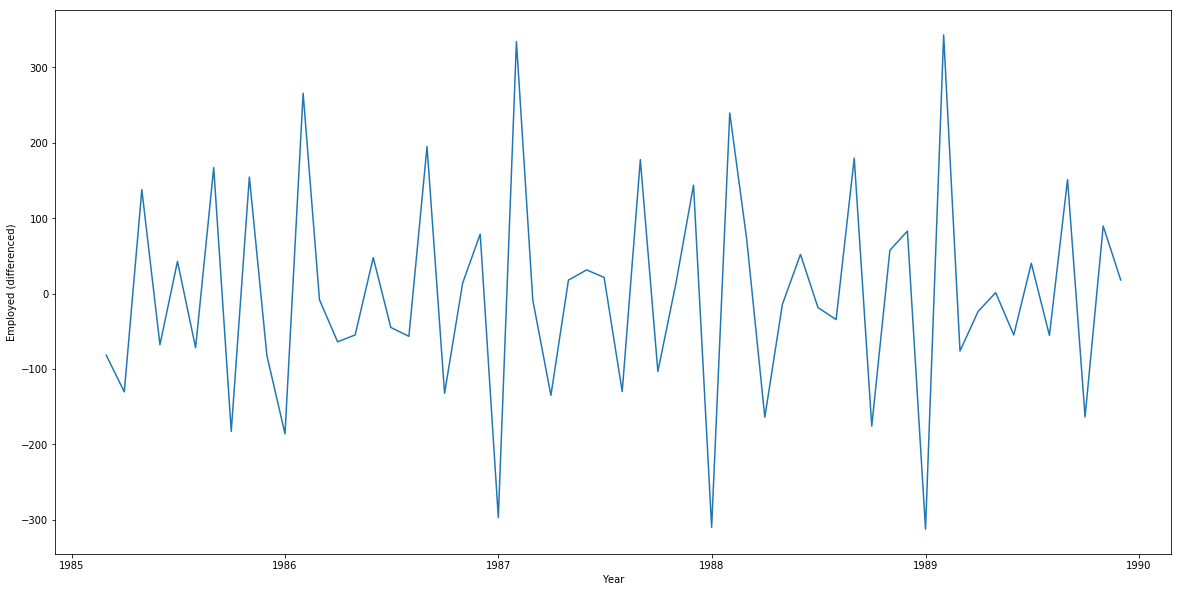

In [9]:
# Differencing - remove non-stationarity.
plt.figure(figsize=(20, 10))
employed_dif = (employed_data.diff()).dropna()
employed_diff = (employed_dif.diff()).dropna()
plt.xlabel('Year')
plt.ylabel('Employed (differenced)')
plt.plot(employed_diff['Employed'])

The time series data has been differenced twice to remove stationarity. You can observe the trend of the modified data using the seasonal decomposition method once again.

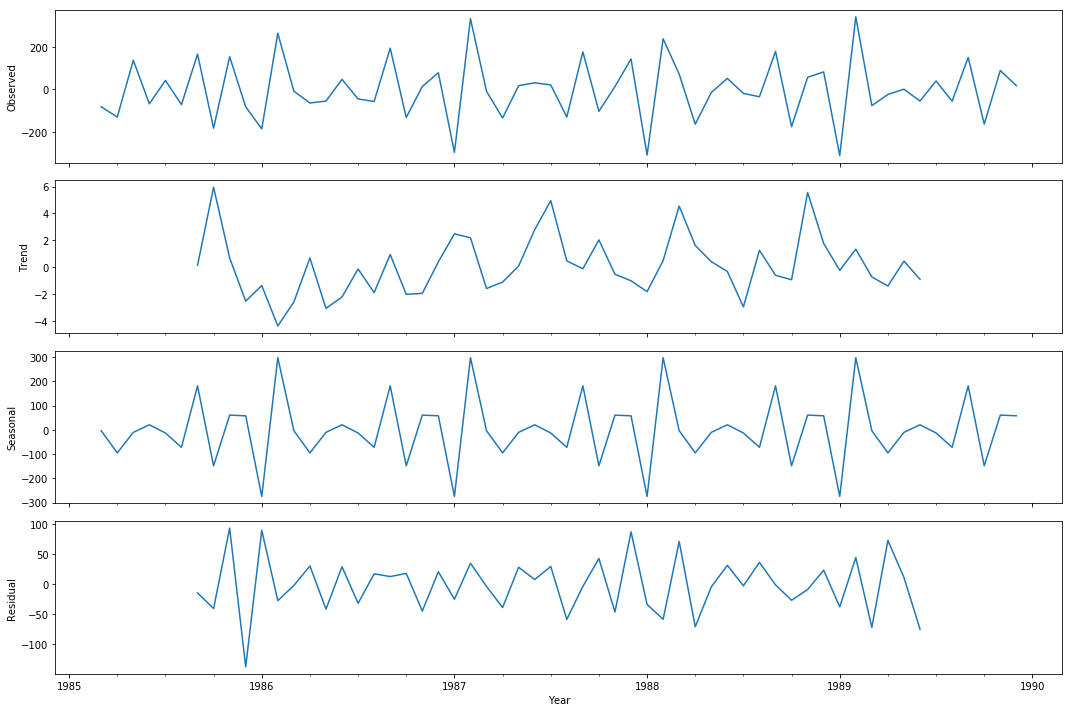

In [10]:
# Decomposition of stationarized time series.
rcParams['figure.figsize'] =15, 10
decomposition = sm.tsa.seasonal_decompose(employed_diff['Employed'], model = 'additive')
fig = decomposition.plot()
plt.xlabel('Year')
plt.show()

From the plot, you can see that there is no observable trend in the differenced time series data. Once again, you can use the Augmented Dicky-Fuller test to confirm that the stationarity of the data as well.

In [11]:
# Augmented Dicky-Fuller test.
dftest = adfuller(employed_diff['Employed'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                 -3.399912
p-value                         0.010962
Number of Lags Used            11.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


Since the `Test Statistic` here is less than the `Critical Values`, we can reject the null hypothesis and we can assume that the series is stationary. As you can see from the decomposition plot and the Dicky-Fuller test, the stationarity has been removed.

<a id='modelselection'></a>
## 4. Model Selection

4.1 [Plot the ACF and PACF plots](#plot)<br>
4.2 [Grid search](#grid)<br>
4.3 [Build model](#build)<br>
4.4 [Forecast](#forecast)

### 4.1 Plot the ACF and PACF plots<a id='plot'></a>

Now, you can run the code below to plot the ACF and PACF plots of the modified stationary data.

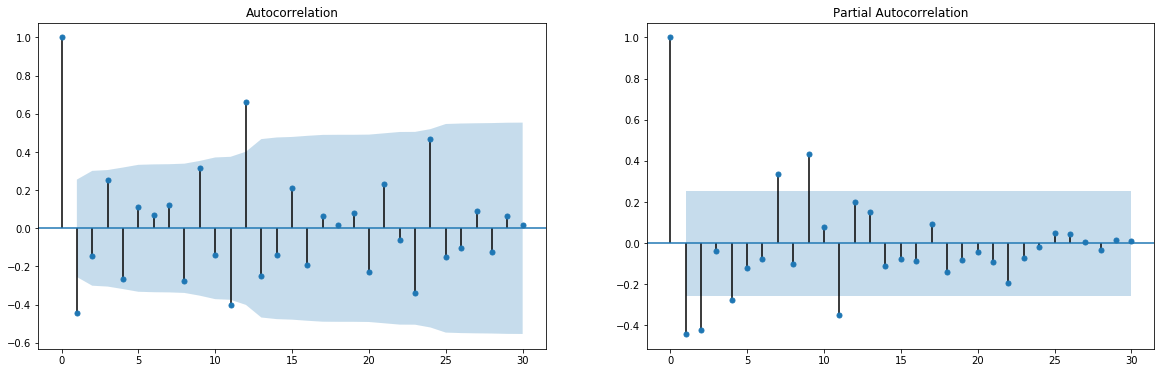

In [12]:
# Visualize the ACF and PACF plots of the stationarized series.
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))
plot_acf(employed_dif['Employed'], ax = ax1, lags = 30)
plot_pacf(employed_dif['Employed'], ax = ax2, lags = 30, method='ywmle')
plt.show()
# autocorrelation_plot(employed_diff['Employed'])

The ACF plot shows that the first lag is significant. So, you can set the moving average value, `q`, to 1.

In the PACF plot, the first lag is significant, so you can set `p` to 1.

### 4.2 Grid Search<a id='grid'></a>

To check the optimal values for the ARIMA parameters, you can perform grid search using the package below.

In [ ]:
# Install the pmdarima package.
!pip install --upgrade pmdarima

In [14]:
# Import auto-arima - grid search for ARIMA.
from pmdarima.arima import auto_arima

Run the following code to compare the various combinations of the ARIMA parameters, as well as the seasonal parameters.

In [15]:
# Perform grid search for the ARIMA model.
#employed_data[:'1988']
stepwise_model = auto_arima(employed_data[:'1988'], start_p=0, start_q=0, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=2, D=1, 
                            trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=379.648, BIC=387.133, Fit time=2.148 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=380.274, BIC=385.887, Fit time=0.182 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 1, 0, 12); AIC=381.648, BIC=391.004, Fit time=68.830 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=395.146, BIC=400.760, Fit time=1.800 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=369.558, BIC=378.914, Fit time=5.6

The parameter set with the lowest `AIC` value (criteria that measures the model) is a good choice to fit the model. As you can see, the lowest `AIC` value is about 353.6, so the optimal parameters are `order = (1, 2, 1)` and `seasonal_order = (1, 1, 0, 12)`.

### 4.3 Build the Model<a id='build'></a>

To build and evaluate a model, we need to split the data set into train and test sets. You can use years 1985-88 as the training data, and year 1989 as the test data.

Because this time series object has a seasonal pattern, you can use the SARIMA (Seasonal ARIMA) model to build the model.

**Train the Model**

In [16]:
# Build the model on the training data with optimized parameters.
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = SARIMAX(employed_data[:'1988'], order=(1, 2, 1),  seasonal_order=(1, 1, 0, 12), enforce_stationarity=False, enforce_invertibility=False)
mod_fit = mod.fit()

mod2 = SARIMAX(employed_data['1985':], order=(1, 2, 1),  seasonal_order=(1, 1, 0, 12), enforce_stationarity=False, enforce_invertibility=False)
mod_fit2 = mod2.fit()

In [17]:
# ARIMA model summary.
mod_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           Employed   No. Observations:                   48
Model:             SARIMAX(1, 2, 1)x(1, 1, 0, 12)   Log Likelihood                -104.374
Date:                            Tue, 05 Mar 2019   AIC                            216.749
Time:                                    19:35:28   BIC                            224.234
Sample:                                01-01-1985   HQIC                           219.577
                                     - 12-01-1988                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1943      0.263     -0.739      0.460      -0.710       0.321
ma.L1         -1.0000   1087.816     -0.001      0.999   -2133.080    2131.080
ar.S.L12      -0.3312      0.202     -1.641      0.101      -0.727       0.064
sigma2      1069.9478   1.16e+06      0.001      0.999   -2.28e+06    2.28e+06
===================================================================================
Ljung-Box (Q):                       19.15   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.51   Prob(JB):                         0.35
Heteroskedasticity (H):               1.35   Skew:                             0.70
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Run this cell to plot the diagnostics for the standardized residuals of the data.

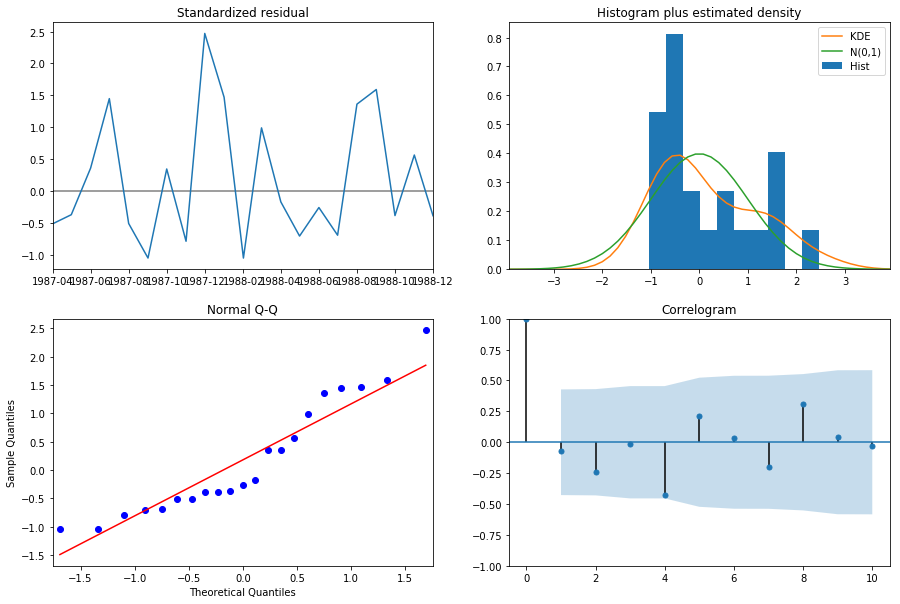

In [18]:
# Plot the diagnostics.
mod_fit.plot_diagnostics()
plt.show()

### 4.4 Forecast<a id='forecast'></a>

Now that you've built the model, you can use it to predict the number of employed people in the year 1989 and compare it with the observed numbers. You can run the code below to plot the the observed values with the predicted values and a 95% confidence interval.

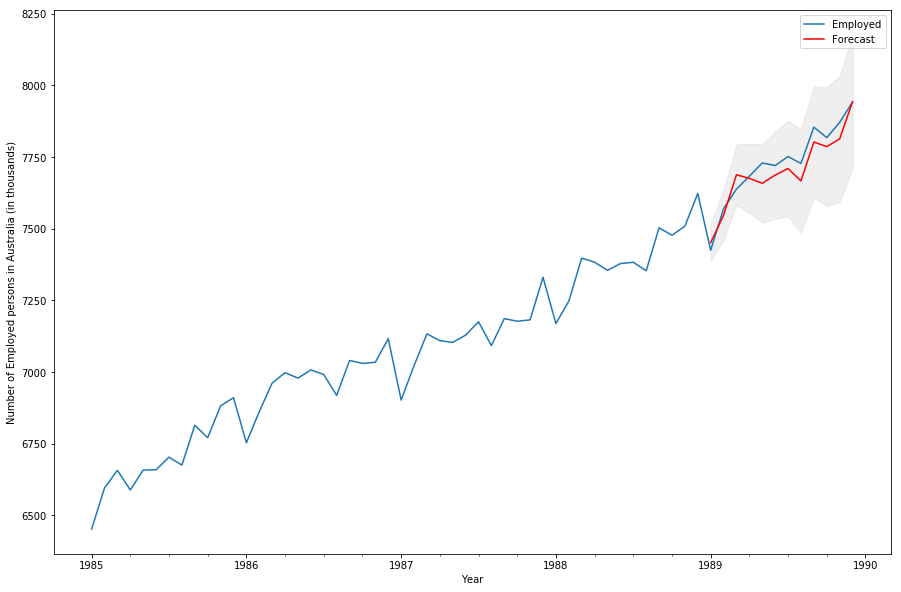

In [19]:
# Predict on the test data.
ax = employed_data['1985':'1989'].plot(label='Observed')
forecast = mod_fit.get_forecast(12)
forecast.predicted_mean.plot(ax=ax, style = 'r', label='Forecast')

# Calculate and visualize the 95% confidence interval.
predict_ci = forecast.conf_int(alpha = .05, cols = None)
ci = predict_ci.loc['1989-01-01':'1989-12-01']
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='dimgray', alpha=0.1)

# Add the labels to the plot.
plt.xlabel('Year')
plt.ylabel('Number of Employed persons in Australia (in thousands)')
plt.legend()

In the plot above, you can observe how the predicted values (in red) measure up to the observed values (in blue) during the year 1989. As you can see, the time series model built in this notebook does a good job of predicting the number of employed Australians close to the observed numbers.

<a id='summary'></a>
##  5. Summary and next steps

You successfully completed this notebook and learned how to create a Time Series model. You can now analyze a time series data to check its stationarity, stationarize the series if necessary, and find the optimal parameters for the ARIMA model. You've learned how to use this model to forecast data with a confidence interval.

Check out our <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts.

### Data citations

Australian Bureau of Statistics (2012). <a href="https://datamarket.com/data/list/?q=provider:tsdl" target="_blank" rel="noopener noreferrer">Data Market</a>.

### Author

**Ananya Kaushik** is a Data Scientist at IBM.

Copyright Â© 2018, 2019 IBM. This notebook and its source code are released under the terms of the MIT License. The data set is separately licensed under the terms of the Default open license (https://datamarket.com/data/license/0/default-open-license.html).

<div style='background:#F5F7FA; height:110px; padding: 2em; font-size:14px;'>
<span style='font-size:18px;color:#152935;'>Love this notebook? </span>
<span style='font-size:15px;color:#152935;float:right;margin-right:40px;'>Don't have an account yet?</span><br>
<span style='color:#5A6872;'>Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style='border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;'><a href='https://ibm.co/wsnotebooks' target='_blank' style='color: #3d70b2;text-decoration: none;'>Sign Up</a></span><br>
</div>